# Designed of the Experiment

## Importing the Packages

In [1]:
import yfinance as yf
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Gathering and pre-processing the raw data

In [35]:
stock_list = ["0050.TW", "0051.TW", "0052.TW", 
              "0053.TW", "0054.TW", "0055.TW", 
              "0056.TW", "0057.TW", "006203.TW",
              "006204.TW", "006208.TW", "00633L.TW", 
              "00631L.TW", "00632R.TW", "00701.TW", 
              "00713.TW", "00731.TW"]
stocks = ""
for stock in stock_list:
    stocks += i+" "

In [36]:
X = yf.download(stocks, start="2020-01-01", end="2022-06-30")
y = yf.download("^TWII", start="2020-01-01", end="2022-06-30")

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
X_train = X.iloc[:int(len(X)*0.8)]['Adj Close']
X_val = X.iloc[int(len(X)*0.8):int(len(X)*0.9)]['Adj Close']
X_test = X.iloc[int(len(X)*0.9):]['Adj Close']
y_train = y.iloc[:int(len(X)*0.8)]['Adj Close']
y_val = y.iloc[int(len(X)*0.8):int(len(X)*0.9)]['Adj Close']
y_test = y.iloc[int(len(X)*0.9):]['Adj Close']

## Get βs of all subsets

In [37]:
def fit_linear_reg(X, Y):
    model_k = linear_model.LinearRegression(fit_intercept=False)
    model_k.fit(X, Y)
    Params = [*model_k.coef_]
    return Params

In [48]:
from tqdm import tnrange, tqdm_notebook

p = len(stock_list)
feature_list, Param_list, numb_features = [], [], []
for p in tnrange(1, len(X_train.columns) + 1, desc='Loop...'):
    for combo in itertools.combinations(X_train.columns, p):
        tmp_result = fit_linear_reg(X_train[list(combo)], y_train)
        Param_list.append(tmp_result)
        feature_list.append(combo)
        numb_features.append(len(combo))


<ipython-input-48-d74026a130ec>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1, len(X_train.columns) + 1, desc='Loop...'):


In [57]:
fit = pd.DataFrame({'numb_features': numb_features,
                  'features': feature_list, 
                   "Parameters": Param_list})

## Get out-sample MSE of all subsets

In [59]:
error = []
for i in range(len(fit)):
    error.append(mean_squared_error(y_val, X_val[list(fit["features"][i])] @ fit["Parameters"][i]))
fit["Out-sample MSE"] = error
fit

,numb_features,features,Parameters,Out-sample MSE
0,1,"(0050.TW,)",[123.78829570443297],1.799320e+05
1,1,"(0051.TW,)",[315.60426095684414],1.191930e+06
2,1,"(0052.TW,)",[138.7011418485813],2.182358e+05
3,1,"(0053.TW,)",[258.843038718209],1.071318e+05
4,1,"(0054.TW,)",[525.5228202208385],2.937121e+06
...,...,...,...,...
131066,16,"(0050.TW, 0051.TW, 0052.TW, 0054.TW, 0055.TW, ...","[41.21774367107797, 55.16930019218947, -22.153...",1.909056e+04
131067,16,"(0050.TW, 0051.TW, 0053.TW, 0054.TW, 0055.TW, ...","[37.12382697541411, 67.6349733701882, -68.2403...",7.981527e+03
131068,16,"(0050.TW, 0052.TW, 0053.TW, 0054.TW, 0055.TW, ...","[16.933433151588247, 5.51769731467852, -16.523...",1.537501e+04
131069,16,"(0051.TW, 0052.TW, 0053.TW, 0054.TW, 0055.TW, ...","[62.55905927753936, 3.9334479199588945, -70.83...",7.505539e+03


## Best Subset Selection

In [144]:
best_model = fit.loc[fit['Out-sample MSE'] == fit['Out-sample MSE'][fit['Out-sample MSE'].idxmin()]]

In [149]:
best_model

,numb_features,features,Parameters,Out-sample MSE
95484,10,"(0050.TW, 0051.TW, 0054.TW, 0056.TW, 0057.TW, ...","[4.949246910508601, 41.080263812246116, 28.008...",1108.309675


In [151]:
index = fit['Out-sample MSE'].idxmin()
best_features = []
best_parameters = []
for feature in best_model['features'][index]:
    best_features.append(feature)
for parameter in best_model['Parameters'][index]:
    best_parameters.append(parameter)
best_fit = X_val[best_features] @ best_parameters
best_fit

Date
2021-12-24    17969.418226
2021-12-27    18052.716956
2021-12-28    18190.604895
2021-12-29    18234.756521
2021-12-30    18201.608592
2022-01-03    18269.085991
2022-01-04    18499.346819
2022-01-05    18471.972377
2022-01-06    18343.249355
2022-01-07    18180.425837
2022-01-10    18266.909460
2022-01-11    18273.848820
2022-01-12    18348.089775
2022-01-13    18447.541438
2022-01-14    18446.318014
2022-01-17    18582.489506
2022-01-18    18396.704272
2022-01-19    18186.651422
2022-01-20    18247.494651
2022-01-21    17916.392470
2022-01-24    18005.504597
2022-01-25    17767.799964
2022-01-26    17785.590072
2022-02-07    17910.490961
2022-02-08    18032.723741
2022-02-09    18107.685044
2022-02-10    18310.088365
2022-02-11    18280.253547
2022-02-14    17988.675644
2022-02-15    17975.842200
2022-02-16    18159.542094
2022-02-17    18221.442792
2022-02-18    18231.160603
2022-02-21    18228.740345
2022-02-22    17975.583070
2022-02-23    18033.953953
2022-02-24    17666.266

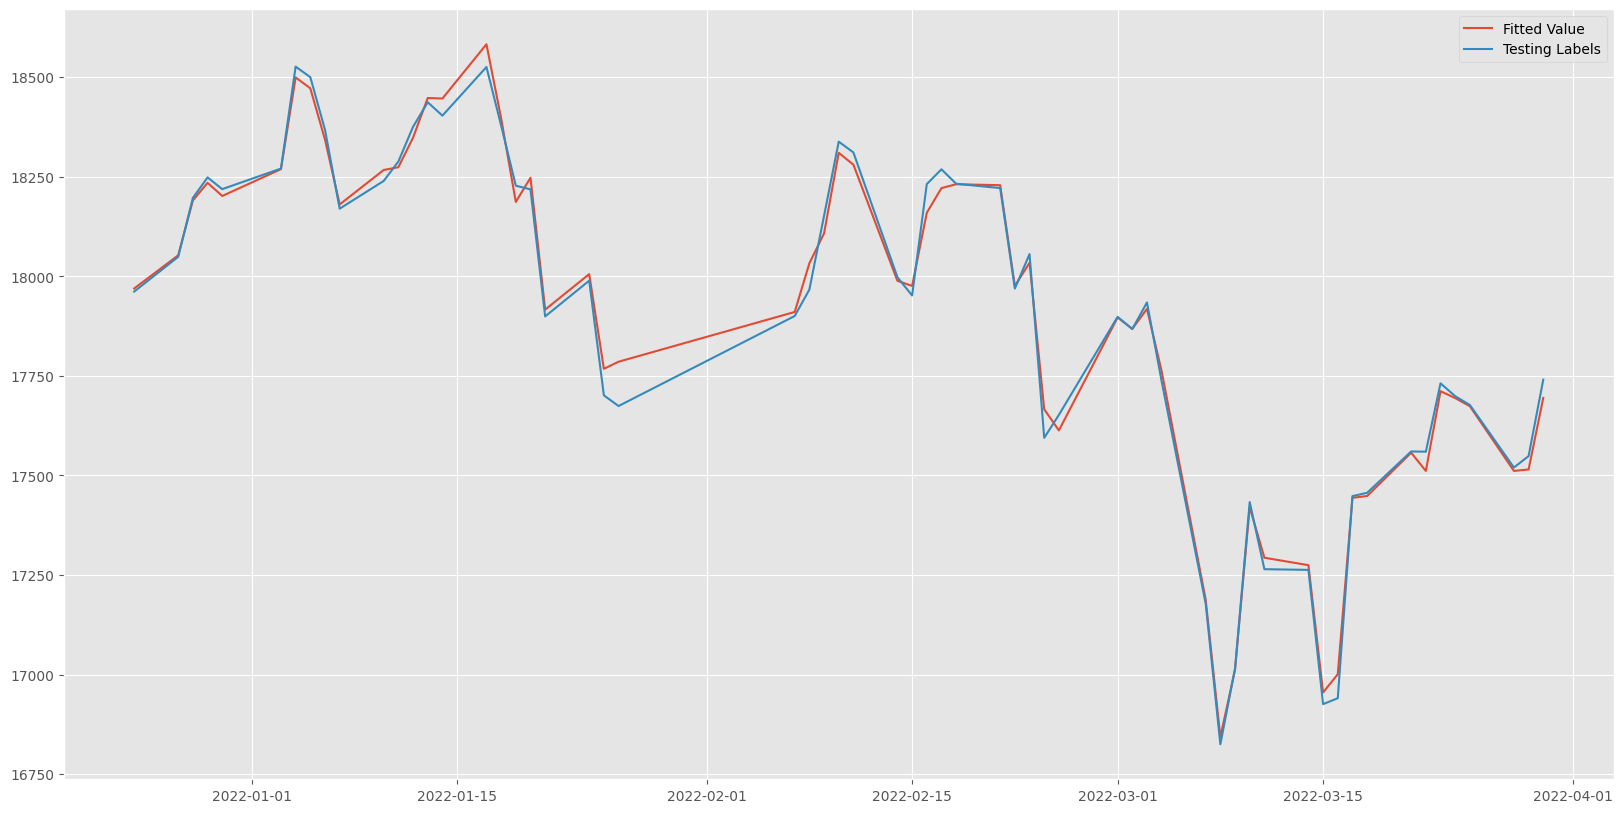

In [152]:
plt.figure(figsize=(20,10))
plt.plot(best_fit, label = "Fitted Value")
plt.plot(y_val, label = "Testing Labels")
plt.legend()
plt.show()

## Get fitted value of all subsets

In [148]:
index = fit['Out-sample MSE'].idxmin()
best_features = []
best_parameters = []
for feature in best_model['features'][index]:
    best_features.append(feature)
for parameter in best_model['Parameters'][index]:
    best_parameters.append(parameter)
fitv = X_test[best_features] @ best_parameters
fitv

Date
2022-03-31    17717.322373
2022-04-01    17566.244293
2022-04-06    17479.663776
2022-04-07    17237.775291
2022-04-08    17269.504655
                  ...     
2022-06-23    15134.458405
2022-06-24    15176.485028
2022-06-27    15500.357291
2022-06-28    15317.910994
2022-06-29    15180.088508
Length: 61, dtype: float64

# Numerical results

In [146]:
import scipy
r,_ = scipy.stats.pearsonr(fitv, y_test)
print(r, mean_squared_error(y_test, fitv))

0.9972214139772638


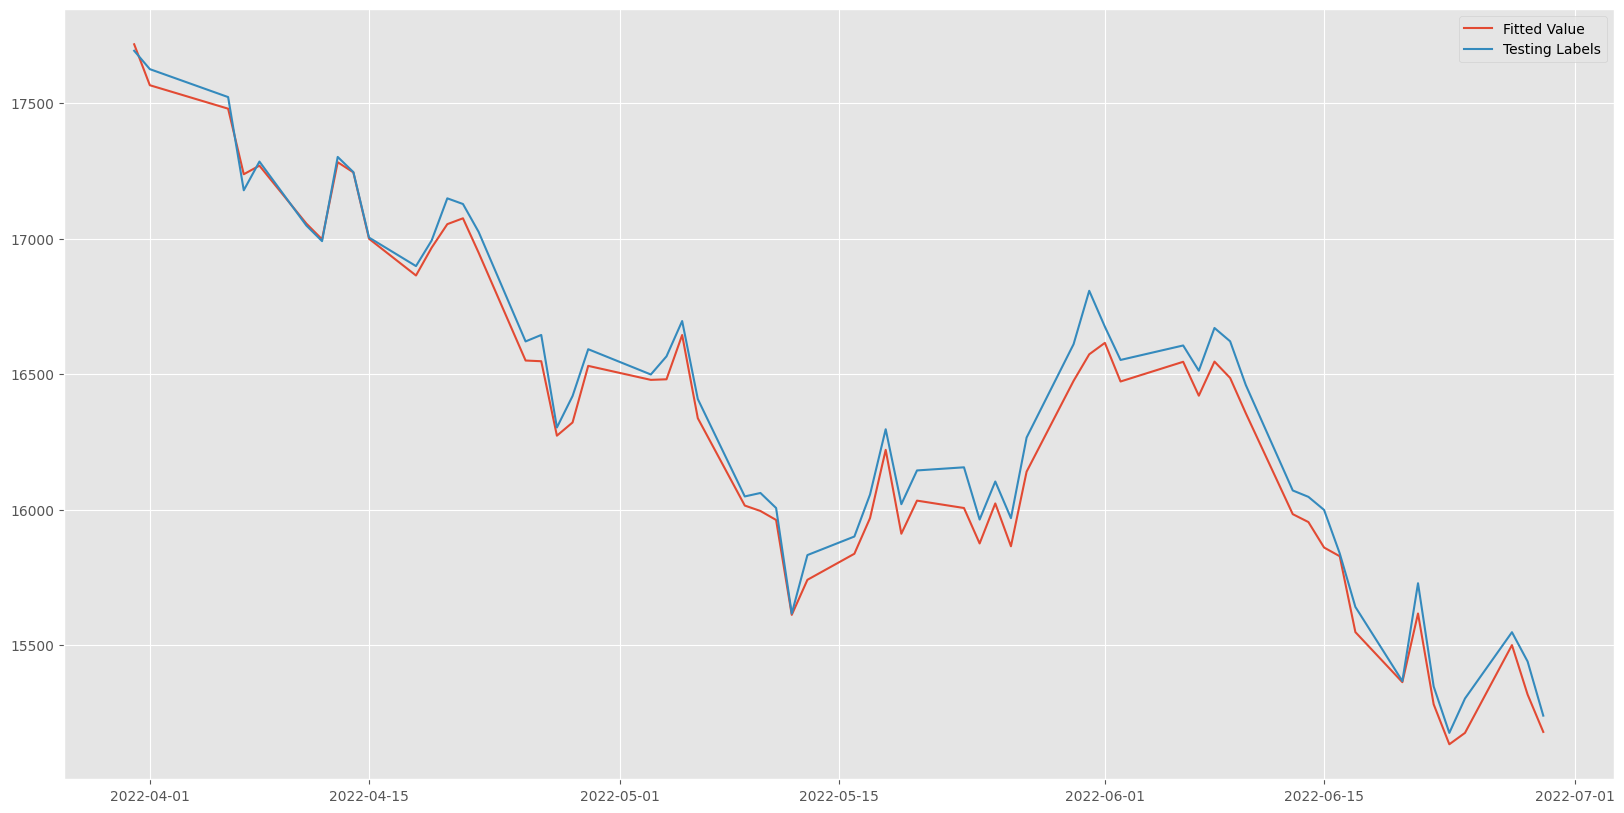

In [147]:
plt.figure(figsize=(20,10))
plt.plot(fitv, label = "Fitted Value")
plt.plot(y_test, label = "Testing Labels")
plt.legend()
plt.show()